In [79]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from skimage import measure
from skimage.measure import regionprops
import matplotlib.patches as patches


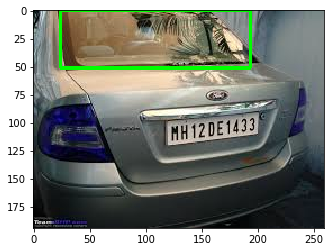

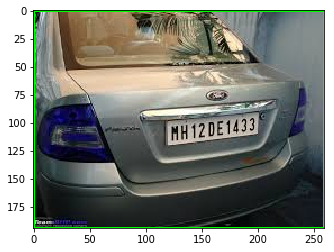

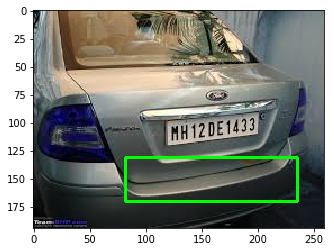

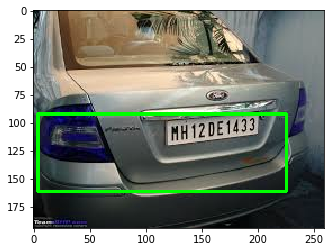

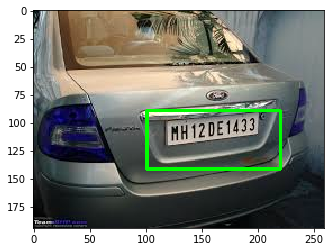

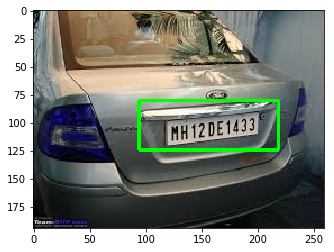

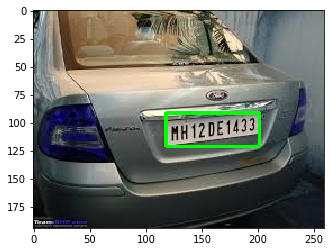

In [210]:
#Image Pre-processing

im = cv2.imread('Data/car9.jpeg')
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

# sobelx = cv2.Sobel(imgray,cv2.CV_8U,1,0,ksize=3)

# ret,thresh = cv2.threshold(imgray,127,255,0)

thresh = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,7)

im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

image_area = im.shape[0]*im.shape[1]

plate_like_objects=[]
dims=[]
for i,cnt in enumerate(contours) :
    
    area = cv2.contourArea(cnt)
    
    if(area > 0.01*image_area):
        x,y,w,h = cv2.boundingRect(cnt)
        img = cv2.rectangle(im.copy(),(x,y),(x+w,y+h),(0,255,0),2)

        plate = thresh[y:y+h,x:x+w]
        dims.append([x,y,w,h])
        plate_like_objects.append(plate)
        plt.imshow(img)
        plt.show()

In [211]:
#Detection

number_plate = 999
for i in range(len(plate_like_objects)):
    
    image = plate_like_objects[i]

    license_plate = np.invert(image)

    labelled_plate = measure.label(license_plate)
    
    character_dimensions = (0.2*license_plate.shape[0], 0.60*license_plate.shape[0], 0.01*license_plate.shape[1], 0.40*license_plate.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions

    characters = []
    max_char = 8
    
    for regions in regionprops(labelled_plate):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
            
            roi = license_plate[y0:y1, x0:x1]
            resized_char = resize(roi, (20, 20))
            characters.append(resized_char)

    if ((len(characters)>max_char) and (len(characters)<11)):
        number_plate = i
                       

/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


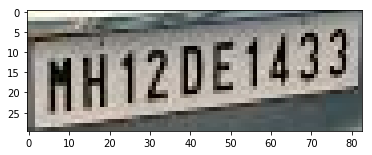

In [212]:
#Detected Number Plate
if number_plate != 999:
    x,y,w,h = dims[number_plate]
    image = im[y:y+h,x:x+w]
    plt.imshow(image)
else:
    print("No Plate Detected")

/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/local/ALGOANALYTICS/arun/arun_work/ML/py3.6_NN/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


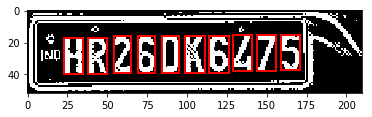

In [208]:
#Segmentation

if number_plate!= 999:
    
    x,y,w,h = dims[number_plate]
    
    image = thresh[y:y+h,x:x+w]
#     plt.imshow(image)
    
    license_plate = np.invert(image)
    
    labelled_plate = measure.label(license_plate)
    
    character_dimensions = (0.2*license_plate.shape[0], 0.70*license_plate.shape[0], 0.01*license_plate.shape[1], 0.40*license_plate.shape[1])
    min_height, max_height, min_width, max_width = character_dimensions
   
    fig, ax1 = plt.subplots(1)
    ax1.imshow(license_plate, cmap="gray")

    number_plate_char = []
    column_list_x = []
    column_list_y = []
    
    for regions in regionprops(labelled_plate):
        y0, x0, y1, x1 = regions.bbox
        region_height = y1 - y0
        region_width = x1 - x0

        if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
            roi = license_plate[y0:y1, x0:x1]
            
            # draw a red bordered rectangle over the character.
            rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                           linewidth=2, fill=False)
            
            ax1.add_patch(rect_border)
            
            resized_char = resize(roi, (20, 20))
            number_plate_char.append(resized_char)
            
            # this is just to keep track of the arrangement of the characters
            column_list_x.append(x0)
            column_list_y.append(y0)
    
    
else:
    print("No plate detected")

plt.show()


In [147]:
len(number_plate_char)

10

In [209]:
#Recognition

import os
from sklearn.externals import joblib

current_dir = os.path.dirname(os.path.realpath('__file__'))
model_dir = os.path.join(current_dir, 'models/svc/svc.pkl')
model = joblib.load(model_dir)

classification_result = []
for each_character in number_plate_char:
    # converts it to a 1D array
    each_character = each_character.reshape(1, -1);
    result = model.predict(each_character)
    classification_result.append(result)

print(classification_result)

plate_string = ''
for eachPredict in classification_result:
    plate_string += eachPredict[0]

print(plate_string)

# it's possible the characters are wrongly arranged
# since that's a possibility, the column_list will be
# used to sort the letters in the right order

column_list_y = [int(x > min(column_list_y)+10) for x in column_list_y]
column_list_copy = column_list_x[:]

zipped_pairs = zip(column_list_y, column_list_x)
column_list = [x for _, x in sorted(zipped_pairs)]

# column_list_copy = column_list[:]
# column_list = sorted(column_list, key=lambda x: x[1])
rightplate_string = ''
for each in column_list:
    rightplate_string += plate_string[column_list_copy.index(each)]

print(rightplate_string)

[array(['4'], dtype='<U1'), array(['7'], dtype='<U1'), array(['5'], dtype='<U1'), array(['Z'], dtype='<U1'), array(['6'], dtype='<U1'), array(['D'], dtype='<U1'), array(['K'], dtype='<U1'), array(['6'], dtype='<U1'), array(['H'], dtype='<U1'), array(['R'], dtype='<U1')]
475Z6DK6HR
HRZ6DK6475
